In [161]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pbn import operations as ops
from pbn import conversions as convert
from pbn import functions as fxn
from scipy import ndimage
%matplotlib inline

In [162]:
def get_na_counts(df):
    return df.apply(pd.Series.isnull).apply(pd.Series.value_counts)

(900, 723, 3)


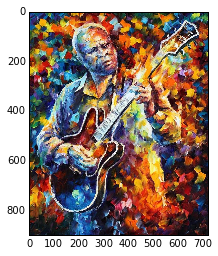

In [448]:
import matplotlib.image as matimg
#img_d = matimg.imread('/Users/eczech/Downloads/google.png')
img_rgb = matimg.imread('/Users/eczech/Downloads/afremov_bbking.png')
print(img_rgb.shape)
plt.imshow(img_rgb)

In [449]:
#img_rgb = img_rgb[:200,:400,:]

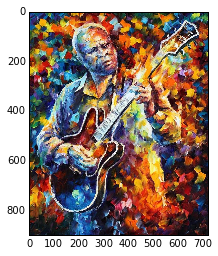

In [450]:
plt.imshow(img_rgb)

In [451]:
img_lab = convert.rgb_to_lab(img_rgb)

In [452]:
def unravel(d, color_cols=['l', 'a', 'b']):
    n2d = d.shape[0] * d.shape[1]
    colors = np.empty((n2d, 5))
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            z = i * d.shape[1] + j
            colors[z] = [float(i), float(j)] + list(d[i, j, :])
    return pd.DataFrame(colors, columns=['x', 'y'] + color_cols)

In [453]:
#alpha = .002 # best so far for gmm
alpha = .004 # also good for gmm
#alpha = 10
img_df = unravel(img_lab)
img_df[['l', 'a', 'b']] = img_df[['l', 'a', 'b']] * alpha
img_df.head()

,x,y,l,a,b
0,0,0,0.138338,0.017247,-0.164449
1,0,1,0.246500,-0.027042,-0.161878
2,0,2,0.181279,-0.009071,-0.160252
3,0,3,0.181279,-0.009071,-0.160252
4,0,4,0.161637,-0.001464,-0.158474


In [482]:
from sklearn.mixture import DPGMM, GMM
#from sklearn.cluster import MiniBatchKMeans
#mm = DPGMM(n_components=1000, alpha=.1, n_iter=50)
#mm = GMM(n_components=150)
mm = GMM(n_components=500)
#mm = MiniBatchKMeans(n_clusters=500)
mm.fit(img_df)
img_pred = mm.predict(img_df)

/Users/eczech/anaconda/envs/research3.3/lib/python3.3/site-packages/sklearn/cluster/k_means_.py:1273: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


In [483]:
mm.converged_

AttributeError: 'MiniBatchKMeans' object has no attribute 'converged_'

In [484]:
len(np.unique(img_pred))

500

In [487]:
#mm.means_.shape
mm.cluster_centers_.shape

(500, 5)

In [488]:
img_all = pd.concat([img_df, pd.Series(img_pred)], axis=1)
img_all = img_all.rename(columns={0: 'c'})
img_all.index.name = 'order'
img_all.head()

,x,y,l,a,b,c
order,,,,,,
0,0,0,0.138338,0.017247,-0.164449,86
1,0,1,0.246500,-0.027042,-0.161878,86
2,0,2,0.181279,-0.009071,-0.160252,86
3,0,3,0.181279,-0.009071,-0.160252,86
4,0,4,0.161637,-0.001464,-0.158474,86


In [489]:
len(img_all['c'].unique())

500

In [490]:
color_clusters = img_all.groupby('c')[['l', 'a', 'b']].mean()
color_clusters.head()

,l,a,b
c,,,
0,0.118327,0.139390,0.094392
1,0.188026,0.042835,0.010649
2,0.187510,-0.003457,-0.112346
3,0.040721,0.023596,-0.067882
4,0.222389,-0.006021,0.001524


In [491]:
n_before = len(img_all)
img_merged = img_all.reset_index()\
    .merge(color_clusters.reset_index(), on='c', suffixes=['', '_m'])\
    .sort('order').set_index('order')
assert n_before == len(img_merged),\
    'Some rows were somehow lost during join: size before = {}, size after = {}'.format(n_before, len(img_merged))
assert np.all(img_merged.apply(np.isfinite).apply(np.all)), 'Merged data frame has NA values somehow'
img_merged.iloc[1000:1010]

,x,y,l,a,b,c,l_m,a_m,b_m
order,,,,,,,,,
1000,1,277,0.035454,0.069339,0.041532,441,0.112499,0.124916,0.101235
1001,1,278,0.038581,0.068271,0.035577,441,0.112499,0.124916,0.101235
1002,1,279,0.040498,0.068405,0.034163,441,0.112499,0.124916,0.101235
1003,1,280,0.065843,0.070403,0.026585,441,0.112499,0.124916,0.101235
1004,1,281,0.125143,0.069910,0.021217,441,0.112499,0.124916,0.101235
1005,1,282,0.162919,0.076720,0.023921,441,0.112499,0.124916,0.101235
1006,1,283,0.179441,0.081366,0.036087,441,0.112499,0.124916,0.101235
1007,1,284,0.175107,0.087247,0.054353,116,0.149306,0.099666,0.123211
1008,1,285,0.187088,0.087805,0.071508,116,0.149306,0.099666,0.123211


In [492]:
import imp
imp.reload(convert)
imp.reload(ops)
imp.reload(fxn)

<module 'pbn.functions' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/functions.py'>

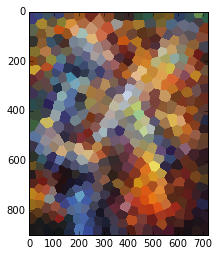

In [493]:
img_color = img_merged[[c for c in img_merged.columns if c.endswith('_m')]]
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
#img_color = fxn.denoise_raw_img(img_color, 1)
plt.imshow(img_color)
plt.imsave('/tmp/pbn_prelim.png', img_color)

## Collapse Colors

In [464]:
avg_color_cols = [c for c in img_merged.columns if c.endswith('_m')]

In [465]:
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

def collapse_colors(flt_cluster, color_cols, n_colors=10, alpha=1):
    X = flt_cluster[color_cols] / alpha
    mm = GMM(n_components=n_colors)
    y = pd.Series(mm.fit(X).predict(X))
    assert mm.converged_, 'Mixture model did not converge'
    mean_map = dict([ (i, v * alpha) for i, v in enumerate(mm.means_) ])
    flt_cluster[['{}_c'.format(c) for c in color_cols]] = y.map(mean_map).apply(pd.Series)
    flt_cluster['cc'] = y
    return flt_cluster.sort_index(), mm


## Normalize Colors to Clusters

In [466]:
img_clustered, cmm = collapse_colors(img_merged, avg_color_cols, n_colors=25, alpha=alpha)
clustered_color_cols = [c for c in img_clustered.columns if c.endswith('_m_c')]
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,
0,0,0,0.138338,0.017247,-0.164449,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
1,0,1,0.246500,-0.027042,-0.161878,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
2,0,2,0.181279,-0.009071,-0.160252,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
3,0,3,0.181279,-0.009071,-0.160252,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
4,0,4,0.161637,-0.001464,-0.158474,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11


In [467]:
# imp.reload(palettes)

# from pbn import palettes
# palette = pd.DataFrame(palettes.rainbow_all)
# palette = palette.apply(convert._rgb_to_lab, axis=1).apply(pd.Series)
# palette *= alpha
# img_matched = fxn.match_to_palette(img_merged[avg_color_cols], palette)
# img_matched.head()

# img_clustered = img_merged.copy()
# img_clustered[['l_m_p', 'a_m_p', 'b_m_p']] = img_matched
# clustered_color_cols = [c for c in img_clustered.columns if c.endswith('_m_p')]
# img_clustered.head()

# # Show number actually matched
# img_clustered[clustered_color_cols].drop_duplicates()

### Denoise Result

In [468]:
#img_denoised = fxn.denoise_flat_img(img_clustered, img_rgb.shape, ['l_m_c', 'a_m_c', 'b_m_c'], n_iter=3)
#denoise_color_cols = [c for c in img_denoised.columns if c.endswith('_dn')]
#print(denoise_color_cols)
#img_denoised.head()

Index(['l_m_c', 'a_m_c', 'b_m_c'], dtype='object')


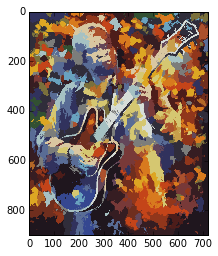

In [469]:
img_color = img_clustered[clustered_color_cols]
print(img_color.columns)
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
#img_color = denoise_raw_img(img_color, 1)
plt.imsave('/tmp/pbn_collapsed.png', img_color)
plt.imshow(img_color)

## Show Cluster Membership

In [494]:
def get_cluster_img(flt_cluster, img_d):
    """ expecting [ c, x, y, l, a, b ] where c is cluster and l, a, and b are color means """
    colors = {}
    res = np.empty_like(img_d)
    for cluster in flt_cluster['c'].unique():
        colors[cluster] = [np.random.rand(), np.random.rand(), np.random.rand()]
    for i, r in flt_cluster[['x', 'y', 'c']].iterrows():
        res[r['x'], r['y']] = colors[r['c']]
    return res

In [495]:
img_clusters = get_cluster_img(img_clustered, img_rgb)

In [497]:
plt.imsave('/tmp/pbn_clusters_rand.png', img_clusters)

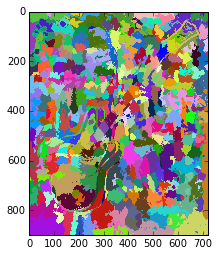

In [496]:
plt.imshow(img_clusters)

# Results

In [470]:
color_matrix = ops.reravel(img_clustered[['cc']], *img_rgb.shape[:2])
color_matrix = np.int64(np.reshape(color_matrix, img_rgb.shape[0:2]))
color_matrix.shape

(900, 723)

In [471]:
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,
0,0,0,0.138338,0.017247,-0.164449,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
1,0,1,0.246500,-0.027042,-0.161878,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
2,0,2,0.181279,-0.009071,-0.160252,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
3,0,3,0.181279,-0.009071,-0.160252,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11
4,0,4,0.161637,-0.001464,-0.158474,109,0.114781,0.027457,-0.124468,0.090564,0.036166,-0.104546,11


In [472]:
# Run this to make sure that the color clusters really only have one color per cluster
img_clustered.groupby('cc').apply(lambda x: len(x[['l_m_c', 'a_m_c', 'b_m_c']].drop_duplicates())).value_counts()
# This should report only "1" with a count equal to the number of clusters

1    25
dtype: int64

In [473]:
collapsed_color_clusters = img_clustered.groupby('cc')\
    .apply(lambda x: x[['l_m_c', 'a_m_c', 'b_m_c']].iloc[0])
collapsed_color_clusters.head()

,l_m_c,a_m_c,b_m_c
cc,,,
0,0.304972,-0.036772,-0.017888
1,0.058002,0.053030,0.008956
2,0.244596,0.132908,0.245263
3,0.183850,0.143034,0.153952
4,0.128123,0.046558,-0.173081


In [474]:
spatial_clusters = ops.cluster_by_proximity(color_matrix, threshold=.8, shrinkage=1, n_iterations=1)

1607 clusters collapsed of 3801


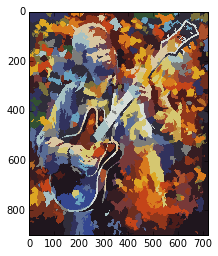

In [475]:
img_reassembled = ops.image_from_clusters(spatial_clusters, collapsed_color_clusters, img_rgb, use_random_color=False)
img_reassembled = convert.lab_to_rgb(img_reassembled / alpha)
plt.imsave('/tmp/pbn_rand.png', img_reassembled)
plt.imshow(img_reassembled)

In [476]:
img_reassembled.shape

(900, 723, 3)

In [477]:
cluster_props = ops.get_cluster_props(spatial_clusters, collapsed_color_clusters, color_matrix)

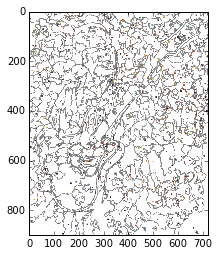

In [498]:
bkg = np.array(convert._rgb_to_lab([1, 1, 1.])) * alpha
edg = np.array(convert._rgb_to_lab([.5, .5, .5])) * alpha
img_pbn = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, size_limit=30, solution=False)
img_pbn = convert.lab_to_rgb(img_pbn / alpha)
matimg.imsave('/tmp/pbn_actual.png', img_pbn)
plt.imshow(img_pbn)

In [521]:
import imp
imp.reload(ops)

<module 'pbn.operations' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/operations.py'>

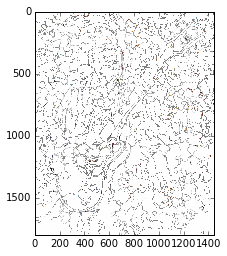

In [522]:
img_pbn_sol = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, size_limit=30, solution=False, scale_factor=2)
img_pbn_sol = convert.lab_to_rgb(img_pbn_sol / alpha)
matimg.imsave('/tmp/pbn_sol.png', img_pbn_sol)
plt.imshow(img_pbn_sol)

In [523]:
img_pbn_sol.shape

(1800, 1446, 3)

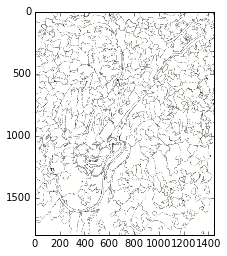

In [526]:
# from scipy import ndimage
# img_pbn_sol_blur = ndimage.gaussian_filter(img_pbn_sol, sigma=1)
# plt.imsave('/tmp/pbn_sol_blur.png', img_pbn_sol_blur)
# plt.imshow(img_pbn_sol_blur)

##Zooming

In [505]:
x = np.empty((4,5,3))
x[:,:] = [1,2,3]
x[0:2]

array([[[ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.]],

       [[ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.]]])

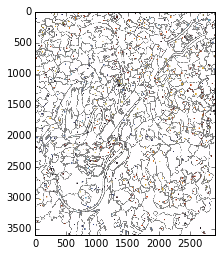

In [479]:
import scipy
img_zoom = scipy.ndimage.zoom(img_pbn, (4, 4, 1), order=1)
matimg.imsave('/tmp/pbn_zoom.png', img_zoom)
plt.imshow(img_zoom)

In [ ]:
import scipy
img_zoom = scipy.ndimage.zoom(img_pbn_sol, (4, 4, 1), order=1)
matimg.imsave('/tmp/pbn_zoom_sol.png', img_pbn_sol)
plt.imshow(img_pbn_sol)

## D

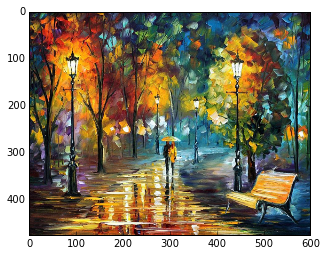

In [157]:
plt.imshow(img_d)

In [94]:
img_color[:1]

array([[[ 28.52951146,  41.8903634 ,  63.85973287],
        [ 28.52951146,  41.8903634 ,  63.85973287],
        [ 29.68364349,  26.02848577,  41.1074676 ],
        ..., 
        [ 19.85763937,  11.52777806,  19.85763943],
        [ 29.68364349,  26.02848577,  41.1074676 ],
        [ 38.47588722,  65.89200525,  86.06265656]]])

In [527]:
words = {
'A': '{0x10,0x28,0x44,0x44,0x7c,0x44,0x44,0x00}',
'B': '{0x78,0x44,0x44,0x78,0x44,0x44,0x78,0x00}',
'C': '{0x38,0x44,0x40,0x40,0x40,0x44,0x38,0x00}',
'D': '{0x70,0x48,0x44,0x44,0x44,0x48,0x70,0x00}',
'E': '{0x7c,0x40,0x40,0x70,0x40,0x40,0x7c,0x00}',
'F': '{0x7c,0x40,0x40,0x70,0x40,0x40,0x40,0x00}',
'G': '{0x38,0x44,0x40,0x40,0x5c,0x44,0x38,0x00}',
'H': '{0x44,0x44,0x44,0x7c,0x44,0x44,0x44,0x00}',
'I': '{0x7c,0x10,0x10,0x10,0x10,0x10,0x7c,0x00}',
'J': '{0x7c,0x08,0x08,0x08,0x08,0x48,0x30,0x00}',
'K': '{0x44,0x48,0x50,0x60,0x50,0x48,0x44,0x00}',
'L': '{0x40,0x40,0x40,0x40,0x40,0x40,0x7c,0x00}',
'M': '{0x44,0x6c,0x54,0x44,0x44,0x44,0x44,0x00}',
'N': '{0x44,0x44,0x64,0x54,0x4c,0x44,0x44,0x00}',
'O': '{0x10,0x28,0x44,0x44,0x44,0x28,0x10,0x00}',
'P': '{0x78,0x44,0x44,0x78,0x40,0x40,0x40,0x00}',
'Q': '{0x38,0x44,0x44,0x44,0x54,0x4c,0x38,0x00}',
'R': '{0x78,0x44,0x44,0x78,0x50,0x48,0x44,0x00}',
'S': '{0x38,0x44,0x40,0x38,0x04,0x44,0x38,0x00}',
'T': '{0x7c,0x10,0x10,0x10,0x10,0x10,0x10,0x00}',
'U': '{0x44,0x44,0x44,0x44,0x44,0x44,0x38,0x00}',
'V': '{0x44,0x44,0x44,0x28,0x28,0x10,0x00,0x00}',
'W': '{0x44,0x44,0x44,0x54,0x54,0x28,0x00,0x00}',
'X': '{0x44,0x44,0x28,0x10,0x28,0x44,0x44,0x00}',
'Y': '{0x44,0x44,0x44,0x28,0x10,0x10,0x10,0x00}',
'Z': '{0x7c,0x04,0x08,0x10,0x20,0x40,0x7c,0x00}'
}

In [536]:
bin(int('0x40', 16))[2:].zfill(8)

'01000000'

In [551]:
alphabet = {}
for k, v in words.items():
    def get_bin(hex_string):
        return bin(int(hex_string, 16))[2:].zfill(8)
    dot_mat = np.zeros((7,5))
    rows = v.replace('{', '').replace('}', '').split(',')
    for i, row in enumerate(rows):
        if i >= 7:
            continue
        for j, val in enumerate(get_bin(row)[1:6]):
            #print(i, j, val, get_bin(row)[1:6])
            dot_mat[i, j] = int(val)
    alphabet[k] = dot_mat
alphabet['A']
        

array([[ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  1.]])